<hr style="border:3px solid coral"></hr>

# Homework #5

<hr style="border:3px solid coral"></hr>

* <a href="#prob1">Problem #1</a> Serial Jacobi solver

* <a href="#prob2">Problem #2</a> Parallel Jacobi solver

In [1]:
from numpy import *
from matplotlib.pyplot import *

<a id="prob1"></a>

<hr style="border:3px solid coral"></hr>

## Problem #1 (serial)

<hr style="border:3px solid coral"></hr>

Approximate the solution to the following elliptic problem using a finite difference scheme and the Jacobi method.   

\begin{equation}
u''(x) = e^{-x^2}, \quad x \in [-1,1]
\end{equation}

subject to $u(-1) = u(1) = 0$.   

The true solution is given by 

\begin{equation}
u_{true}(x) = \frac{1}{2}\left[\sqrt{\pi}\; x \;\mbox{erf}(x) + e^{-x^2}\right] + c_2 x + c_1
\end{equation}


### To Do

* Determine coefficients $c_1$ and $c_2$ in the true solution so that boundary conditions are satisfied.

* Discretize the problem using a second order centered difference scheme.  

* Compute the solution using the Jacobi method.  Use the matrix-free method and the iteration

\begin{equation}
\mathbf u_{k+1} = \mathbf u_k + D^{-1}(\mathbf F - A\mathbf u_k)
\end{equation}

Use 

\begin{equation}
\Vert \mathbf u_{k+1} - \mathbf u_k \Vert_\infty < \tau = 10^{-12}
\end{equation}

as stopping criteria. 
* Report the inf-norm of the error and residual for $N = 32$, $N=64$ and $N=128$.   


\begin{eqnarray}
\mbox{error : } \quad e &= &\Vert \mathbf u - \mathbf u_{true} \Vert_\infty \\
\mbox{residual : } \quad r &= &\Vert \mathbf F - A \mathbf u \Vert_\infty
\end{eqnarray}

where $\mathbf u$ is the computed solution. 

Show that you are getting second order accuracy.   **Hint:** Show that the error is reduced by a factor of 4 each time you double $N$. 

* Plot your solution for $N = 64$. 

#### Tips

* Solve for values $u_i = u(x_i)$, $x_i = -1 + ih$, $i = 0,1,\dots N$ and $h = 2/N$. 

* Recall that the inf-norm $\Vert \cdot \Vert_\infty$ of a vector $\mathbf v$ is given by 

\begin{equation}
\Vert \mathbf v \Vert_\infty = \max_{i} |v_i|
\end{equation}

* To handle the boundary conditions, you can use the trick we discussed in class and assign values to $u_{-1}$ and $u_{N+1}$ using 

\begin{equation}
\frac{u_1 + u_{-1}}{2} = u_{true}(-1) = 0 \quad \Longrightarrow \quad u_{-1} = -u_{1}
\end{equation}

and 

\begin{equation}
\frac{u_{N-1} + u_{N+1}}{2} = u_{true}(1) = 0 \quad \Longrightarrow \quad u_{N+1} = -u_{N-1}
\end{equation}

Allocate space for ghost values $u_{-1}$ and $u_{N+1}$ and before calling the matrix-vector multipy, you can make the assignment

    uk[-1] = u[1];
    uk[N+1] = u[N-1];
    ...
    matvec(N,u,Lu);

Then matrix-vector routine can be written as

    void matvec(int N, double *u, double *L)
    {
        for(int i = 0; i < N+1; i++)
            L[i] = (u[i-1] - 2*u[i] + u[i+1]); 
    }

### Compute coefficients $c_1$, $c_2$

Check that $u(-1) = u(1) = 0$. 

In [2]:
import scipy
from scipy.special import erf

def utrue(x,c1,c2):
    return (sqrt(pi)*x*erf(x) + exp(-x**2))/2 + c2*x + c1

In [3]:
from numpy.linalg import solve
# Compute c1, c2
A = [[1,1] , [1, -1]]
b = [[-0.5*(exp(-1) + sqrt(pi)*erf(1))],\
           [-0.5*(exp(-1) -sqrt(pi)*erf(-1))]]
c1,c2 = solve(A,b)
if utrue(-1,c1,c2) ==  utrue(1,c1,c2) == 0:
         print(f"c1 = {c1}, c2 = {c2}")
    

c1 = [-0.93076385], c2 = [-0.]


In [4]:
%%file prob1.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <mpi.h>

double c2 = 0;
double c1 = -0.930763853398148;

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return &mem[m];
}

void free_1d(double **x, int m)
{
    free(&(*x)[-m]);
    *x = NULL;
}


double utrue(double x)
{
    double pi = M_PI;
    double utrue = (sqrt(pi)*x*erf(x) + exp(-x*x))/2.0 + c2*x + c1;
    return utrue;    
}

double rhs(double x)
{
    double upp = exp(-x*x);
    return upp;
}

void matvec(int N, double *u, double *L)
{
    // Apply BC
    u[-1] =  -u[1];
    
    u[N+1] = - u[N-1];
    
    for(int i = 0; i < N+1; i++)
    {
        L[i] = (u[i-1] - 2*u[i] + u[i+1]); 
    }
}

void jacobi(int N, double *F, double *u, double tol, int kmax, int prt)
{
    // Jacobi iteration
    double *u_old = allocate_1d(N+1, 1);
    double *Lu = allocate_1d(N+1,0);

    double update;
    int i, j, iter;
    double error;
  
    for (i = 0; i <= N; i++) {
        u_old[i] = u[i] = 0;
    }
    
    // Iterate using Jacobi method
    for (iter = 0; iter < kmax; iter++) 
    {
        matvec(N,u_old,Lu);
        error = 0.0;
        for (i = 0; i <= N; i++) {
            update= -0.5*(F[i] - Lu[i]);
            u[i] = u_old[i]+update ;
            error = fmax(fabs(update), error);
        }

        
       // printf("%5d %12.4e\n",iter,error);
        if (error < tol) 
        {
            break;
        }

        // Copy u to u_old
        for (i = 0; i <= N; i++) {
            u_old[i]=u[i];
        }
    }
    printf("Number of iteration = %d", iter);

    free_1d(&u_old,1);
    free_1d(&Lu,0);
}




int main(int argc, char** argv)
{
    int N = atoi(argv[1]);
    double *u = allocate_1d(N+1, 1);
    double *u_true = allocate_1d(N+1,1);
    double *F = allocate_1d(N+1,0);
    double *LU = allocate_1d(N+1, 0);
    int prt = 1;
    double a = -1.0;
    double b = 1.0;
    double h = (b - a)/N;
    double tol = 1e-12;
    int kmax = 1e6;
    for (int i =0; i<=N; i++)
    {
        F[i] = pow(h,2)*rhs(a + i*h);
        u_true[i] = utrue(a + i*h);
    } 
    u_true[-1] = -u_true[1];
    u_true[N+1] = -u_true[N-1];
    jacobi(N, F,u,tol, kmax, prt);
   
   matvec(N,u,LU);
    
   double er;
   double maxres = 0.0;
   double maxerr = 0.0;
    for(int i = 0; i < N+1; i++)
    {
        double r = fabs(F[i] - LU[i]);
        maxres = fmax(r,maxres);
    }
    for (int i = 0; i<=N; i++)
    {
        double er = fabs(u[i] - u_true[i]);
        maxerr = fmax(er,maxerr);
    }
    
    printf("\n");
    printf("Error norm : %12.4e\n",maxerr);
    printf("Residual : %12.4e\n",maxres);
    printf("-------------------------\n");
    
    FILE *fout = fopen("prob1.dat","w");
    if (fout == NULL) 
    {
        perror("Unable to create file");
        exit(1);
    }
    fwrite(&N, sizeof(int), 1, fout);
    fwrite(&a, sizeof(double), 1, fout);
    fwrite(&b, sizeof(double), 1, fout);
    fwrite(&u[0], sizeof(double), N+1, fout);
    fclose(fout);
    
    free_1d(&u_true,1);
    free_1d(&u,1);
    free_1d(&LU,0);
    free_1d(&F,0);
    return 0;
    
}



Overwriting prob1.c


In [5]:
%%bash

rm -rf prob1.o prob1

mpicc -o prob1 prob1.c

### Run code and get output (serial)

In [6]:
import subprocess
import shlex
import os


# mpirun command
shell_cmd = 'mpirun -n 1 ./prob1 {N:d}'.format

for i in range(0,5):
    N = 2**(3+i);
    cmd = shell_cmd(N=N)
    arg_list = shlex.split(cmd) 

    # Run output
    output = subprocess.run(arg_list)

Number of iteration = 307
Error norm :   1.4834e-02
Residual :   1.8082e-12
-------------------------
Number of iteration = 1179
Error norm :   3.6999e-03
Residual :   1.9369e-12
-------------------------
Number of iteration = 4447
Error norm :   9.2446e-04
Residual :   1.9944e-12
-------------------------
Number of iteration = 16659
Error norm :   2.3108e-04
Residual :   1.9980e-12
-------------------------
Number of iteration = 62053
Error norm :   5.7765e-05
Residual :   1.9996e-12
-------------------------


In [7]:
%%bash

rm -rf prob1.o prob1

mpicc -o prob1 prob1.c

mpirun -n 1 ./prob1 64

Number of iteration = 16659
Error norm :   2.3108e-04
Residual :   1.9980e-12
-------------------------


### Accuracy of solution (serial)

In [8]:
# Errors from running at N=8,16,32,64, 128
# Iterations : 307, 1179, 4447, 16659, 62053
e = array([1.4834e-02, 3.6999e-03, 9.2446e-04, 2.3108e-04, 5.7765e-05]).reshape((5,1))

with printoptions(formatter={'float' : "{:.4f}".format}):
    print(log2(e[:-1]/e[1:]))


[[2.0033]
 [2.0008]
 [2.0002]
 [2.0001]]


### Check file size (serial)

In [9]:
import os

stats = os.stat("prob1.dat")
print(f"File size          : {stats.st_size:d} bytes")

fout = open("prob1.dat","rb")
N = np.fromfile(fout,dtype=int, count=1)[0]
fout.close()

esize = (N+1)*8 + 2*8 + 4
print(f"Expected file size : {esize:d} bytes")

File size          : 540 bytes
Expected file size : 540 bytes


In [10]:
dt = np.dtype([('N',np.int32),\
               ('a',np.float64), \
               ('b',np.float64),\
               ('u',(np.float64,N+1))])

fout = open("prob1.dat","rb")
N,a,b,u = np.fromfile(fout,dtype=dt, count=1)[0]
fout.close()

### Plot the solution (serial)

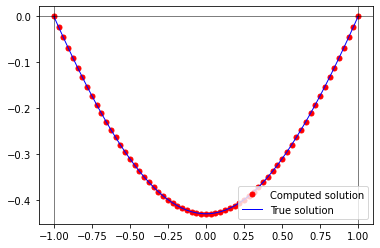

In [11]:
figure(1)
clf()

x = linspace(a,b,N+1);

ut = utrue(x,c1,c2)

plot(x,u,'ro',ms=5,label='Computed solution');
plot(x,ut,'b-',lw=1,label='True solution');

kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(x=-1,**kwargs)
axvline(x=1,**kwargs)

legend(loc=4);

<hr style="border:3px solid coral"></hr>

## Problem #2 (Parallel)

<hr style="border:3px solid coral"></hr>

Implement a parallel version of the solver you wrote in problem #1.


In [12]:
%%file prob2.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include <mpi.h>
double c2 = 0;
double c1 = -0.930763853398148;

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return &mem[m];
}

void free_1d(double **x, int m)
{
    free(&(*x)[-m]);
    *x = NULL;
}


double utrue(double x)
{
    double pi = M_PI;
    double utrue = (sqrt(pi)*x*erf(x) + exp(-x*x))/2.0 + c2*x + c1;
    return utrue;    
}

double rhs(double x)
{
    double upp = exp(-x*x);
    return upp;
}

void matvec(int N, double *u, double *L)
{
    
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

     if (rank > 0)
        {
            int tag = 0;
            int sender = rank - 1;
            MPI_Recv(&u[-1],1,MPI_DOUBLE,sender,tag,MPI_COMM_WORLD, MPI_STATUS_IGNORE);
            
            tag = 1;
            int dest = rank - 1;
            MPI_Send(&u[1],1,MPI_DOUBLE,dest,tag,MPI_COMM_WORLD);
            
           
        }
        if (rank < nprocs - 1)

        {
            
            int tag = 0;
            int dest = rank + 1;
            MPI_Send(&u[N-1],1,MPI_DOUBLE,dest,tag,MPI_COMM_WORLD);
            
            tag = 1;
            int sender = rank + 1;
            MPI_Recv(&u[N+1],1,MPI_DOUBLE,sender,tag,MPI_COMM_WORLD, MPI_STATUS_IGNORE);     
        }
    for(int i = 0; i <= N; i++)
    {
        L[i] = (u[i-1] - 2*u[i] + u[i+1]);
        
    }
}

void jacobi(int N, double *F, double *u, double tol, int kmax, int prt)
{
    
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    double *u_old = allocate_1d(N+1, 1);
    double *Lu = allocate_1d(N+1,0);
     double max_error = 0.0;
    
    double update;
    int i, j, iter;
    double error;
  
    for (i = 0; i <= N; i++) 
    {
        u_old[i] = u[i] = 0;
    }

    for (iter = 0; iter <= kmax; iter++) 
    { 

        if (rank == 0)
            {
                   u_old[-1] =  -u_old[1];
            }
            if (rank == nprocs -1)
            {
                   u_old[N+1] = - u_old[N-1];  
            }

        
        matvec(N,u_old,Lu);
        
        error = 0.0;
    
        for (i = 0; i < N+1; i++) 
            {
            update= -0.5*(F[i] - Lu[i]);
            u[i] = u_old[i]+update ;
            error = fmax(fabs(update), error);
           
            }
        MPI_Allreduce(&error, &max_error, 1, MPI_DOUBLE, MPI_MAX, MPI_COMM_WORLD);

        if (max_error < tol) 
        {
            break;
        }
        
          for (i = 0; i <N+1 ; i++) 
        {
            u_old[i]=u[i];
        }  
    }

    if (rank == 0 && prt == 1) 
    {
        printf("Number of iterations = %d\n", iter);
    }
    free_1d(&u_old,1);
    free_1d(&Lu,0);
}

int main(int argc, char **argv) 
{

    // Initialize MPI
     MPI_Init(&argc, &argv);
    
    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    // Define problem parameters
     int N = atoi(argv[1]);
    double a = -1.0;
    double b = 1.0;
    double h = (b-a)/N;
    double tol = 1e-12;
    int kmax = 1e6;
    int prt = 1;

    // Define local variables for each process
   
    int N_local = N/nprocs;
    
    double a_local = a + rank * N_local * h;
    double b_local = a_local + N_local * h;
    
    double *F_local = allocate_1d(N_local+1,0);
    double *LU_local = allocate_1d(N_local+1,0);
    double *u_local = allocate_1d(N_local+1,1);
    double *utrue_local = allocate_1d(N_local+1,1);
    double h_local = (b_local - a_local)/N_local;
   
    for (int i =0; i<=N_local; i++)
    {
        double x = a_local + i*h_local;
        F_local[i] = pow(h_local,2)*rhs(x);
        utrue_local[i] = utrue(x); 
    } 
    jacobi(N_local, F_local, u_local, tol, kmax, prt);
    
    if (rank == 0)
    {
     u_local[-1] = -u_local[1];
    utrue_local[-1] = -utrue_local[1];
    }
        
    
    if (rank == nprocs -1)
    {
    u_local[N_local+1] = -u_local[N_local - 1];  
    utrue_local[N_local + 1] = -utrue_local[N_local - 1];
    }
        
    
    matvec(N_local,u_local,LU_local);
    
    double maxres = 0.0;
    double r = 0.0;
    for(int i = 0; i < N_local+1 ; i++)
    {
        r = fabs(F_local[i] - LU_local[i]);
        maxres = fmax(r,maxres);  
    }
    double maxerr = 0.0;
    double er = 0.0;
    for (int i =0 ; i<N_local+1; i++)
    {
        er = fabs(u_local[i] - utrue_local[i]);
        maxerr = fmax(er,maxerr);
    }
    
    MPI_Reduce(&er, &maxerr, 1, MPI_DOUBLE, MPI_MAX, 0, MPI_COMM_WORLD);
    MPI_Reduce(&r, &maxres, 1, MPI_DOUBLE, MPI_MAX, 0, MPI_COMM_WORLD);
    if (rank == 0)
    {
     
      printf("Error norm = %12.4e\n", maxerr ); 
      printf("Maximum Residual = %12.4e\n", maxres );
      printf("-------------------------\n");
    }
        
     

    if (rank == 0)
    {        
        double U[N+1];
        for (int i = 0; i <= N_local; i++)
        {
            U[i] = u_local[i];
        }
        for (int i = 1; i < nprocs; i++) 
        {  
            MPI_Recv(&U[i * N_local], N_local+1, MPI_DOUBLE, i, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        }
        FILE *fout = fopen("prob2.out","w");   
        fwrite(&N,sizeof(int),1,fout);
        fwrite(&a,sizeof(double),1,fout);
        fwrite(&b,sizeof(double),1,fout);
        fwrite(U,sizeof(double),N+1,fout);
        fclose(fout);       
         
    }
    else
    {
            MPI_Send(u_local, N_local+1, MPI_DOUBLE, 0, 0, MPI_COMM_WORLD);
    }
    
    free_1d(&F_local,0);
    free_1d(&u_local,1);
    free_1d(&LU_local,0);
    free_1d(&utrue_local,1);
    
   
    
    MPI_Finalize();

    return 0;
}


Overwriting prob2.c


Compare results to (serial results) : 

    N = 8
    Iteration count     :          307
    Error (inf-norm)    :   1.4834e-02
    Residual (inf-norm) :   9.0417e-13    
    
    N = 32
    Iteration count     :         4447
    Error (inf-norm)    :   9.2446e-04
    Residual (inf-norm) :   9.9720e-13    

In [13]:
%%bash

rm -rf prob2.o prob2

mpicc -o prob2 prob2.c

In [14]:
import subprocess
import shlex
import os


# mpirun command
shell_cmd = 'mpirun -n 4 ./prob2 {N:d}'.format

for i in range(0,5):
    N = 2**(3+i);
    cmd = shell_cmd(N=N)
    arg_list = shlex.split(cmd) 

    # Run output
    output = subprocess.run(arg_list)

Number of iterations = 307
Error norm =   1.4834e-02
Maximum Residual =   1.8082e-12
-------------------------
Number of iterations = 1179
Error norm =   3.6999e-03
Maximum Residual =   1.9369e-12
-------------------------
Number of iterations = 4447
Error norm =   9.2446e-04
Maximum Residual =   1.9944e-12
-------------------------
Number of iterations = 16659
Error norm =   2.3108e-04
Maximum Residual =   1.9980e-12
-------------------------
Number of iterations = 62053
Error norm =   5.7765e-05
Maximum Residual =   1.9996e-12
-------------------------


In [15]:
# Errors from running at N=8, 16, 32, 64, 128

# Report errors
e = array([1.4834e-02, 3.6999e-03, 9.2446e-04, 2.3108e-04, 5.7765e-05]).reshape((5,1))

with printoptions(formatter={'float' : "{:.4f}".format}):
    print(log2(e[:-1]/e[1:]))


[[2.0033]
 [2.0008]
 [2.0002]
 [2.0001]]


In [16]:
%%bash

rm -rf prob2.o prob2

mpicc -o prob2 prob2.c

mpirun -n 4 ./prob2 64

Number of iterations = 16659
Error norm =   2.3108e-04
Maximum Residual =   1.9980e-12
-------------------------


### Accuracy of solution (parallel)

### Check file size

In [17]:
import os

stats = os.stat("prob2.out")
print(f"File size          : {stats.st_size:d} bytes")

fout = open("prob2.out","rb")
N = np.fromfile(fout,dtype=int, count=1)[0]
fout.close()

esize = (N+1)*8 + 2*8 + 4
print(f"Expected file size : {esize:d} bytes")

File size          : 540 bytes
Expected file size : 540 bytes


In [18]:
dt = np.dtype([('N',np.int32),\
               ('a',np.float64), \
               ('b',np.float64),\
               ('u',(np.float64,N+1))])

fout = open("prob2.out","rb")
N,a,b,u = np.fromfile(fout,dtype=dt, count=1)[0]
fout.close()

### Plot the solution

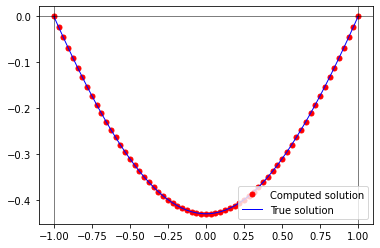

In [19]:
figure(1)
clf()

x = linspace(a,b,N+1)

ut = utrue(x,c1,c2)

plot(x,u,'ro',ms=5,label='Computed solution');
plot(x,ut,'b-',lw=1,label='True solution');

kwargs = {'color' : 'k', 'lw' : 0.5, 'ls' : '-'}
axhline(**kwargs)
axvline(x=-1,**kwargs)
axvline(x=1,**kwargs)

legend(loc=4);